In [170]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot
#from pandas import read_csv, set_option
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
import seaborn as sns

C:\Users\user\anaconda3\envs\py37_32\lib\site-packages\ipykernel_launcher.py:6: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [171]:
import yfinance as yf # yahoo finance API    # pip install yfinance
import investpy # investing.com API          # pip install investpy
from pykrx import stock # krx API           # pip instasll pykrx
import talib as ta # 기술적 분석 (보조지표)
import FinanceDataReader as fdr

In [172]:
start_date=input('YYYY-MM-DD 형식을 지켜 입력해주세요 ex) 2018-01-01 : ')
end_date=input('YYYY-MM-DD 형식을 지켜 입력해주세요 ex) 2020-10-13 : ')

YYYY-MM-DD 형식을 지켜 입력해주세요 ex) 2018-01-01 : 2018-01-01
YYYY-MM-DD 형식을 지켜 입력해주세요 ex) 2020-10-13 : 2021-01-13


In [173]:
# investing.com 양식, ex) dd/mm/yyyy
start_date_ = start_date[8:] + '/' + start_date[5:7] + '/' + start_date[:4]
end_date_ = end_date[8:] + '/' + end_date[5:7] + '/' + end_date[:4]

# krx 양식 ex) yyyymmdd
start_date__ = start_date[0:4] + start_date[5:7] + start_date[8:10]
end_date__ = end_date[0:4] + end_date[5:7] + end_date[8:10]

In [174]:
print(start_date_ +  " : " + end_date_)
print(start_date__ +  " : " + end_date__)

01/01/2018 : 13/01/2021
20180101 : 20210113


In [175]:
sam_ = stock.get_market_ohlcv_by_date(start_date__, end_date__, "005930")
sam_.columns = ['Open','High','Low','Close','Volume']
model_samsung = sam_.copy()

In [176]:
model_samsung['date'] = pd.to_datetime(model_samsung.index)

In [177]:
model_samsung.set_index('date', inplace=True)

<AxesSubplot:xlabel='date'>

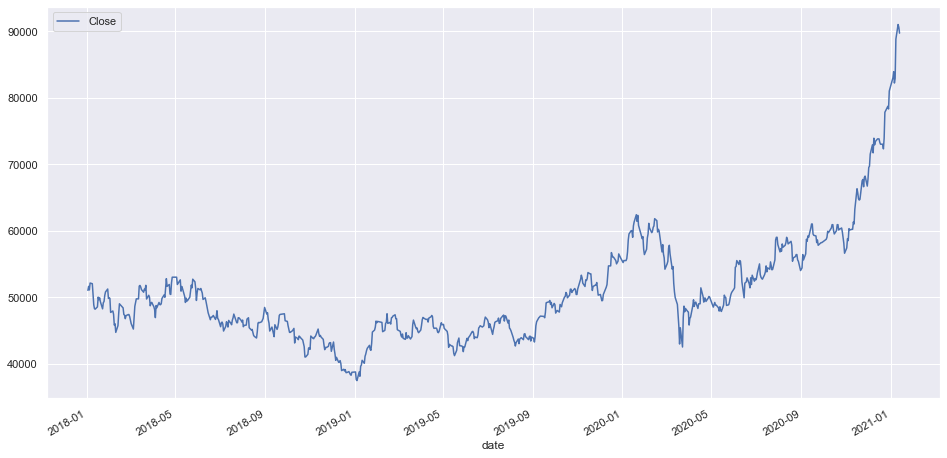

In [178]:
data_samsung.head()
data_samsung.plot(x='date', y='Close', figsize=(16, 8))

In [179]:
print(model_samsung.shape)
print(model_samsung.dtypes)

(746, 5)
Open      int32
High      int32
Low       int32
Close     int32
Volume    int32
dtype: object


In [180]:
lst_label = ['a']
for i in range(len(model_samsung)-1):
    if model_samsung.iloc[i+1]['Close'] == model_samsung.iloc[i]['Close']:
        lst_label.append(2) # 전일 주가 = 당일 주가 : 2
    elif model_samsung.iloc[i+1]['Close'] > model_samsung.iloc[i]['Close']:
        lst_label.append(0) # 전일 주가 < 당일 주가 : 0
    else:
        lst_label.append(1) # 전일 주가 > 당일 주가 : 1
model_samsung['Labeling'] = lst_label
model_samsung = model_samsung.drop(model_samsung[model_samsung['Labeling'] == 'a'].index) # 첫 행 삭제
model_samsung = model_samsung.drop(model_samsung[model_samsung['Labeling'] == 2].index) # 전일 주가 = 당일 주가인 행 삭제
model_samsung['Labeling'] = model_samsung['Labeling'].astype("category")
model_samsung = model_samsung.dropna() # 결측치가 있는 행 제거

In [181]:
model_samsung['Labeling']=pd.to_numeric(model_samsung['Labeling'])

In [182]:
# 특정 종목의 일자별 시가총액을 조회
samsung_market_cap = stock.get_market_cap_by_date(start_date__, end_date__, "005930")
samsung_market_cap.columns = ['Market_Value','Volume','Value','Num_Stock']
del samsung_market_cap['Volume']

In [183]:
samsung_market_cap

,Market_Value,Value,Num_Stock
날짜,,,
2018-01-02,329330258,432677351468,129098494
2018-01-03,333203213,518345810160,129098494
2018-01-04,329717554,600531577700,129098494
2018-01-05,336430675,490792925116,129098494
2018-01-08,335785183,435974098536,129098494
...,...,...,...
2021-01-06,490716126,3506903681680,5969782550
2021-01-07,494894973,2726112459660,5969782550
2021-01-08,530116690,5083939899952,5969782550


In [184]:
samsung_df=pd.merge(model_samsung,samsung_market_cap, how='inner', left_index=True, right_index=True)

In [185]:
samsung_df

,Open,High,Low,Close,Volume,Labeling,Market_Value,Value,Num_Stock
2018-01-03,52540,52560,51420,51620,200270,0,333203213,518345810160,129098494
2018-01-04,52120,52180,50640,51080,233909,1,329717554,600531577700,129098494
2018-01-05,51300,52120,51200,52120,189623,0,336430675,490792925116,129098494
2018-01-08,52400,52520,51500,52020,167673,1,335785183,435974098536,129098494
2018-01-09,51460,51720,49980,50400,360272,1,325328205,915580164480,129098494
...,...,...,...,...,...,...,...,...,...
2021-01-06,83300,84500,82100,82200,42089013,1,490716126,3506903681680,5969782550
2021-01-07,82800,84200,82700,82900,32644642,0,494894973,2726112459660,5969782550
2021-01-08,83300,90000,83000,88800,59013307,0,530116690,5083939899952,5969782550
2021-01-11,90000,96800,89500,91000,90306177,0,543250212,8379237727064,5969782550


In [186]:
macd, macdsignal9, macdhist = ta.MACD(model_samsung.Close, fastperiod=12, slowperiod=26, signalperiod=9)
model_samsung['macd'] = macd
model_samsung['macdsignal9'] = macdsignal9
model_samsung['macdhist'] = macdhist

In [187]:
model_samsung = model_samsung.dropna() # 결측치가 있는 행 제거

In [188]:
print(model_samsung.describe())

               Open          High           Low         Close        Volume  \
count    675.000000    675.000000    675.000000    675.000000  6.750000e+02   
mean   50522.651852  51091.317037  49983.511111  50553.496296  1.474952e+07   
std     7979.748807   8231.925875   7912.250332   8093.684642  1.010984e+07   
min    37450.000000  37600.000000  36850.000000  37450.000000  1.423130e+05   
25%    45200.000000  45800.000000  44825.000000  45300.000000  8.527124e+06   
50%    48400.000000  49100.000000  47850.000000  48600.000000  1.256007e+07   
75%    54300.000000  54850.000000  53750.000000  54200.000000  1.845645e+07   
max    90300.000000  96800.000000  89500.000000  91000.000000  9.030618e+07   

         Labeling         macd  macdsignal9     macdhist  
count  675.000000   675.000000   675.000000   675.000000  
mean     0.466667   264.858039   232.824776    32.033262  
std      0.499258  1086.354130   974.892604   309.751949  
min      0.000000 -3673.496447 -2885.989689 -1194.05

C:\Users\user\anaconda3\envs\py37_32\lib\site-packages\ipykernel_launcher.py:4: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



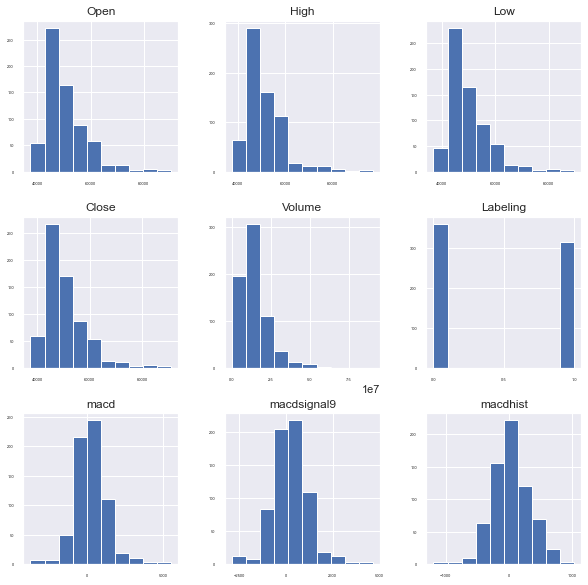

In [189]:
# Plot a histogram for all the columns of the dataframe. This shows the frequency of values in all the columns
sns.set()
model_samsung.hist(sharex = False, sharey = False, xlabelsize = 4, ylabelsize = 4, figsize=(10, 10))
pyplot.show()

Size of the Labels column
Labeling
0    360
1    315
dtype: int64


C:\Users\user\anaconda3\envs\py37_32\lib\site-packages\ipykernel_launcher.py:4: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.

C:\Users\user\anaconda3\envs\py37_32\lib\site-packages\ipykernel_launcher.py:8: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



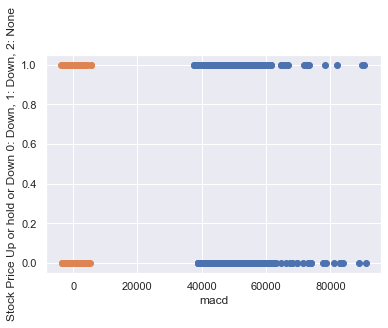

In [190]:
pyplot.scatter(model_samsung['Close'], model_samsung['Labeling'])
pyplot.xlabel('Close')
pyplot.ylabel('Stock Price Up or hold or Down 0: Up, 1: Down, 2: None')
pyplot.show()
pyplot.scatter(model_samsung['macd'], model_samsung['Labeling'])
pyplot.xlabel('macd')
pyplot.ylabel('Stock Price Up or hold or Down 0: Down, 1: Down, 2: None')
pyplot.show()
print("Size of the Labels column")
print(model_samsung.groupby('Labeling').size())

<AxesSubplot:>

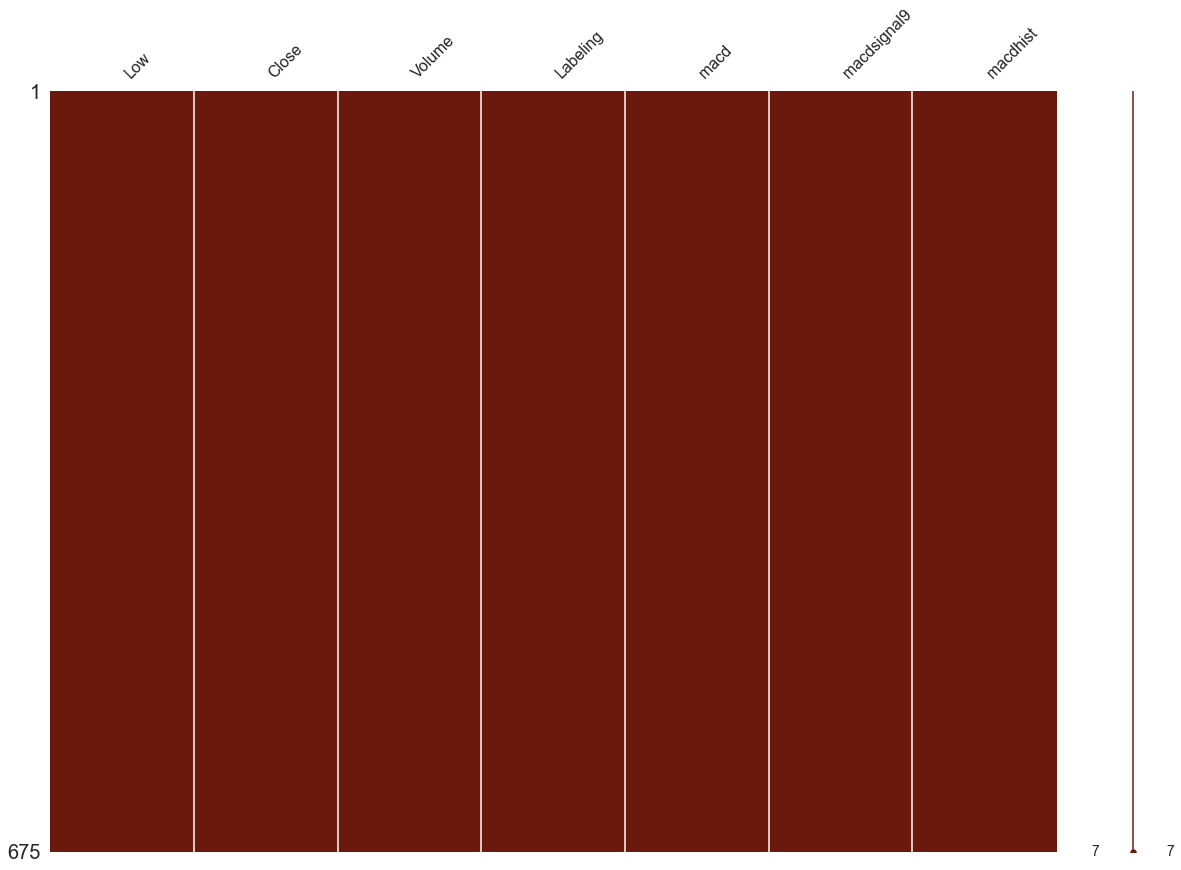

In [191]:
md_copy = model_samsung
md_copy = md_copy.replace(-1, np.NaN)
import missingno as msno
# Nullity or missing values by columns
msno.matrix(df=md_copy.iloc[:,2:39], figsize=(20, 14), color=(0.42, 0.1, 0.05))

C:\Users\user\anaconda3\envs\py37_32\lib\site-packages\ipykernel_launcher.py:6: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



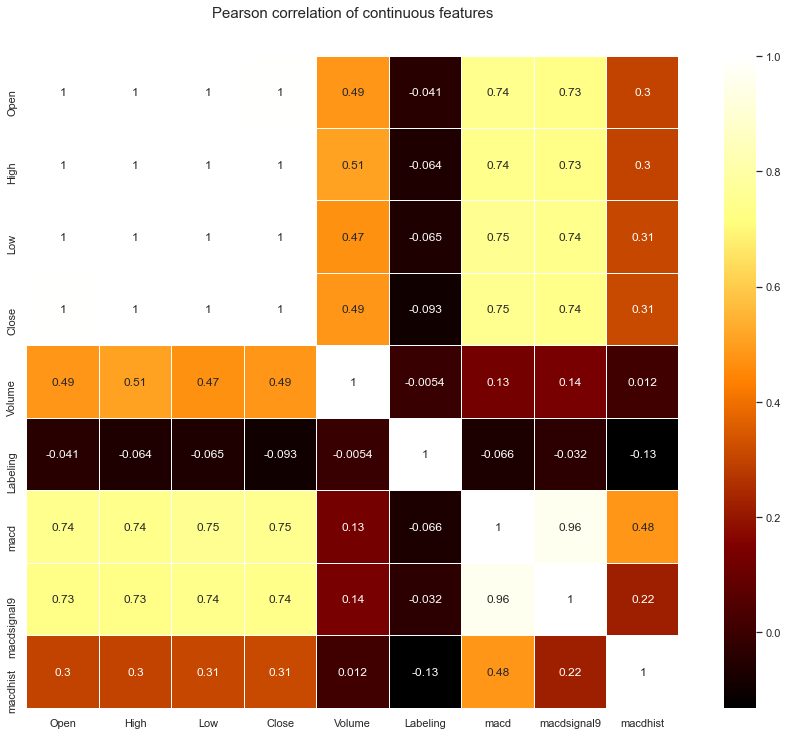

In [192]:
colormap = pyplot.cm.afmhot
pyplot.figure(figsize=(16,12))
pyplot.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(model_samsung.corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)
pyplot.show()

In [193]:
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings

bin_col = model_samsung.columns
zero_list = []
one_list = []
for col in bin_col:
    zero_count = 0
    one_count = 0
    for ix, val in model_samsung[col].iteritems():
        if model_samsung.loc[ix, 'Labeling'] == 0:
            zero_count += 1
        else:
            one_count += 1
    zero_list.append(zero_count)
    one_list.append(one_count)
    
trace1 = go.Bar(
    x=bin_col,
    y=zero_list ,
    name='Zero count'
)
trace2 = go.Bar(
    x=bin_col,
    y=one_list,
    name='One count'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack',
    title='Count of 1 and 0 in binary variables'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

In [194]:
model_samsung = model_samsung.reset_index()

date           datetime64[ns]
Open                    int32
High                    int32
Low                     int32
Close                   int32
Volume                  int32
Labeling                int64
macd                  float64
macdsignal9           float64
macdhist              float64
dtype: object
date           675
Open           675
High           675
Low            675
Close          675
Volume         675
Labeling       675
macd           675
macdsignal9    675
macdhist       675
dtype: int64
date           675
Open           675
High           675
Low            675
Close          675
Volume         675
Labeling       675
macd           675
macdsignal9    675
macdhist       675
dtype: int64
675
472
Observations: 675
X Training Observations: 473
X Testing Observations: 203
y Training Observations: 473
y Testing Observations: 203


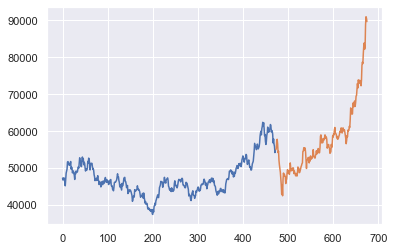

In [195]:
# Print the datatypes and count of the dataframe
print(model_samsung.dtypes)
print(model_samsung.count())
# Recheck the count
print(model_samsung.count())
# Separate the dataframe for input(X) and output variables(y)
X = model_samsung.loc[:,'Open':'Close']
y = model_samsung.loc[:,'Labeling']
# Set the validation size, i.e the test set to 20%
validation_size = 0.20
# Split the dataset to test and train sets
# Split the initial 70% of the data as training set and the remaining 30% data as the testing set
train_size = int(len(X.index) * 0.7)
print(len(y))
print(train_size)
X_train, X_test = X.loc[0:train_size, :], X.loc[train_size: len(X.index), :]
y_train, y_test = y[0:train_size+1], y.loc[train_size: len(X.index)]
print('Observations: %d' % (len(X.index)))
print('X Training Observations: %d' % (len(X_train.index)))
print('X Testing Observations: %d' % (len(X_test.index)))
print('y Training Observations: %d' % (len(y_train)))
print('y Testing Observations: %d' % (len(y_test)))
pyplot.plot(X_train['Close'])
pyplot.plot([None for i in X_train['Close']] + [x for x in X_test['Close']])
pyplot.show()
num_folds = 10
scoring = 'accuracy'
# Append the models to the models list
models = []
models.append(('LR' , LogisticRegression()))
models.append(('LDA' , LinearDiscriminantAnalysis()))
models.append(('KNN' , KNeighborsClassifier()))
models.append(('CART' , DecisionTreeClassifier()))
models.append(('NB' , GaussianNB()))
models.append(('SVM' , SVC()))
models.append(('RF' , RandomForestClassifier(n_estimators=50)))
models.append(('XGBoost', XGBClassifier()))

In [196]:
# Evaluate each algorithm for accuracy
results = []
names = []
'''
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg) '''

for name, model in models:
    clf = model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accu_score = accuracy_score(y_test, y_pred)
    print(name + ": " + str(accu_score))

LR: 0.7931034482758621
LDA: 0.7733990147783252
KNN: 0.7044334975369458
CART: 0.6699507389162561
NB: 0.5517241379310345
SVM: 0.6009852216748769
RF: 0.6945812807881774
[17:32:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost: 0.6650246305418719


C:\Users\user\anaconda3\envs\py37_32\lib\site-packages\xgboost\sklearn.py:892: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



In [197]:
# prepare the model LDA
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model_lda = LinearDiscriminantAnalysis()
model_lda.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model_lda.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(y_test, predictions))
print("confusion matrix: ")
print(confusion_matrix(y_test, predictions))
print("classification report: ")
print(classification_report(y_test, predictions))

model_xgb = XGBClassifier()
model_xgb.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model_xgb.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(y_test, predictions))
print("confusion matrix: ")
print(confusion_matrix(y_test, predictions))
print("classification report: ")
print(classification_report(y_test, predictions))

accuracy score:
0.7733990147783252
confusion matrix: 
[[89 23]
 [23 68]]
classification report: 
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       112
           1       0.75      0.75      0.75        91

    accuracy                           0.77       203
   macro avg       0.77      0.77      0.77       203
weighted avg       0.77      0.77      0.77       203

[17:32:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy score:
0.6650246305418719
confusion matrix: 
[[70 42]
 [26 65]]
classification report: 
              precision    recall  f1-score   support

           0       0.73      0.62      0.67       112
           1       0.61      0.71      0.66        91

    a

C:\Users\user\anaconda3\envs\py37_32\lib\site-packages\xgboost\sklearn.py:892: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



roc auc is :0.6992739403453689


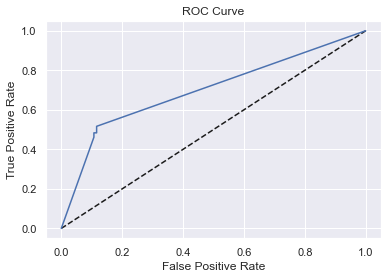

AUC using cross val: [0.67592593 0.87962963 0.83653846 0.82       0.92       0.85858586
 0.78125    0.92       0.93406593 0.70833333]
Mean AUC score is: 0.8334329143079143


C:\Users\user\anaconda3\envs\py37_32\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



In [198]:
# Generating the ROC curve
y_pred_proba = model_lda.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
print("roc auc is :" + str(roc_auc))
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve')
pyplot.show()

# AUC score using cross validation
kfold_val = KFold(n_splits=num_folds, random_state=42)
auc_score = cross_val_score(model_lda, X_test, y_test, cv=kfold_val, scoring='roc_auc')
print("AUC using cross val: " + str(auc_score))
mean_auc = np.mean(auc_score)
print("Mean AUC score is: " + str(mean_auc))

In [199]:
# Scaling Random Forests

model_rf = RandomForestClassifier(n_estimators=1000)
model_rf.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model_rf.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(y_test, predictions))
print("confusion matrix: ")
print(confusion_matrix(y_test, predictions))
print("classification report: ")
print(classification_report(y_test, predictions))

accuracy score:
0.7093596059113301
confusion matrix: 
[[94 18]
 [41 50]]
classification report: 
              precision    recall  f1-score   support

           0       0.70      0.84      0.76       112
           1       0.74      0.55      0.63        91

    accuracy                           0.71       203
   macro avg       0.72      0.69      0.70       203
weighted avg       0.71      0.71      0.70       203



In [200]:
features = model_samsung.drop(['Labeling'],axis=1).columns.values

x, y = (list(x) for x in zip(*sorted(zip(model_xgb.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Feature importance for XGBoost',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances for XGBoost',
     width = 400, height = 400,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

In [201]:
x, y = (list(x) for x in zip(*sorted(zip(model_rf.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Feature importance for Random Forests',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances for Random Forests',
     width = 400, height = 400,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

In [202]:
# XGBoost on Stock Price dataset, Tune n_estimators and max_depth
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib

matplotlib.use('Agg')
model = XGBClassifier()
n_estimators = [150, 200, 250, 450, 500, 550, 1000]
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
print(max_depth)
best_depth = 0
best_estimator = 0
max_score = 0
for n in n_estimators:
    for md in max_depth:
        model = XGBClassifier(n_estimators=n, max_depth=md)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        if score > max_score:
            max_score = score
            best_depth = md
            best_estimator = n
        print("Score is " + str(score) + " at depth of " + str(md) + " and estimator " + str(n))
print("Best score is " + str(max_score) + " at depth of " + str(best_depth) + " and estimator of " + str(best_estimator))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[17:32:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Score is 0.5911330049261084 at depth of 1 and estimator 150
[17:32:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Score is 0.6551724137931034 at depth of 2 and estimator 150
[17:32:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'e

C:\Users\user\anaconda3\envs\py37_32\lib\site-packages\xgboost\sklearn.py:892: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



Score is 0.7093596059113301 at depth of 3 and estimator 150
[17:32:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Score is 0.6995073891625616 at depth of 4 and estimator 150
[17:32:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Score is 0.6502463054187192 at depth of 5 and estimator 150
[17:32:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic'

In [203]:
model_samsung.set_index('date', inplace=True)

In [204]:
imp_features_df = model_samsung[['Low', 'High', 'Close', 'macd']]
Xi_train, Xi_test = X.loc[0:train_size, :], X.loc[train_size: len(X.index), :]
clf = XGBClassifier(n_estimators=500, max_depth=3)
clf.fit(Xi_train, y_train)
yi_pred = clf.predict(Xi_test)
score = accuracy_score(y_test, yi_pred)
print("Score is "+ str(score))

[17:32:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Score is 0.6600985221674877


In [205]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(X)
transformed = pca.transform(X)

transformed.shape
print(type(transformed))

<class 'numpy.ndarray'>


In [206]:
pca_df = pd.DataFrame(transformed)

X_train_pca, X_test_pca = pca_df.loc[0:train_size, :], pca_df.loc[train_size: len(X.index), :]

clf = XGBClassifier(n_estimators=500, max_depth=3)
clf.fit(X_train_pca, y_train)
y_pred_pca = clf.predict(X_test_pca)
score = accuracy_score(y_test, y_pred_pca)
print("Score is "+ str(score))

[17:32:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\anaconda3\envs\py37_32\lib\site-packages\xgboost\sklearn.py:892: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



Score is 0.7438423645320197


In [207]:
pca_matrix = confusion_matrix(y_test, y_pred_pca)
pca_report = classification_report(y_test, y_pred_pca)
print("Confusion Matrix: \n" + str(pca_matrix))
print("Classification report: \n" + str(pca_report))

Confusion Matrix: 
[[83 29]
 [23 68]]
Classification report: 
              precision    recall  f1-score   support

           0       0.78      0.74      0.76       112
           1       0.70      0.75      0.72        91

    accuracy                           0.74       203
   macro avg       0.74      0.74      0.74       203
weighted avg       0.75      0.74      0.74       203



AUC score is 0.796752354788069
roc auc is :0.796752354788069


C:\Users\user\anaconda3\envs\py37_32\lib\site-packages\ipykernel_launcher.py:14: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



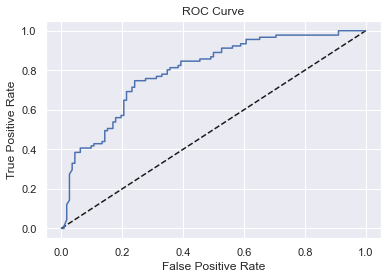

In [208]:
# Generating the ROC curve
y_pred_proba_pca = clf.predict_proba(X_test_pca)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_pca)
roc_auc = auc(fpr, tpr)
print("AUC score is " + str(roc_auc))

# Plot ROC curve
print("roc auc is :" + str(roc_auc))
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve')
pyplot.show()